In [1]:
from IPython.display import HTML
# kudos to harshil: https://stackoverflow.com/questions/27934885/how-to-hide-code-from-cells-in-ipython-notebook-visualized-with-nbviewer
HTML('''<script>
code_show=true; 
function code_toggle() {
 var codeCells = document.getElementsByClassName('jp-Cell-inputArea');
 if (code_show){
    for (var i=0;i<codeCells.length;i++) {
       codeCells[i].style.display='none';
    }
 } else {
    for (var i=0;i<codeCells.length;i++) {
       codeCells[i].style.display='block';
    }
 }
 code_show = !code_show
} 
document.addEventListener('DOMContentLoaded',code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
from gams import *
ws = GamsWorkspace(working_directory = '.')

--- Warning: The GAMS version (28.0.0) differs from the API version (29.1.0).


# How many stocks to select?
We want to get some more insight into the data we produced with our Hypercube job. Thus, we first read the scalar data and transform it into a single large dataframe:

In [3]:
scalars = ( 'trainingdays', 'maxstock', 'error_train', 'error_test' )

scalar_data = { scalar: [] for scalar in scalars}

total_days = 0

with open('hcube_file_names.txt') as f:
    for scenario_to_analyze in f:
        gdx_data_tmp = ws.add_database_from_gdx(scenario_to_analyze.strip())
        for scalar in scalars:
            scalar_data[scalar].append(gdx_data_tmp[scalar].first_record().value)
        if total_days == 0:
            total_days = len({rec.keys[0] for rec in gdx_data_tmp['price']})


In [4]:
import pandas
scalar_df = pandas.DataFrame.from_dict(scalar_data)

scalar_df['error_train_rel'] = scalar_df.apply(lambda row: 
                                                  row['error_train'] / row['trainingdays'], 
                                                axis=1)
scalar_df['error_test_rel'] = scalar_df.apply(lambda row: 
                                                  row['error_test'] / (total_days - row['trainingdays']), 
                                                axis=1)
scalar_df['error_ratio_rel'] = scalar_df.apply(lambda row: 
                                                  row['error_train_rel'] / row['error_test_rel'], 
                                                axis=1)

scalar_df.head()

,trainingdays,maxstock,error_train,error_test,error_train_rel,error_test_rel,error_ratio_rel
0,124.0,3.0,62.878086,208.281044,0.507081,1.627196,0.311629
1,129.0,5.0,35.024747,249.039006,0.271510,2.024707,0.134098
2,104.0,7.0,15.351572,123.909313,0.147611,0.837225,0.176310
3,104.0,3.0,49.686128,221.394472,0.477751,1.495909,0.319372
4,114.0,3.0,56.805983,344.276732,0.498298,2.494759,0.199738


Now that we have the data in the shape we want, we can plot it. Let's first look at the training error:

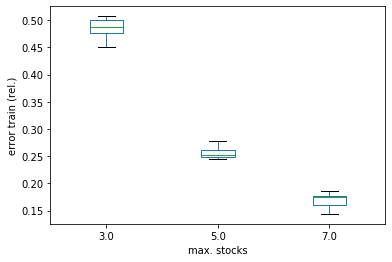

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt

df = scalar_df.pivot(index='trainingdays', columns='maxstock', values='error_train_rel')
df.plot.box()
plt.xlabel('max. stocks')
plt.ylabel('error train (rel.)')
plt.show()

This result is not very surprising: The more stocks we allow the model to select, the less training errors we get. Additionally, if we increase the number of training days, the error increases as we have more data to approximate. Let's now look at the error in the test phase:

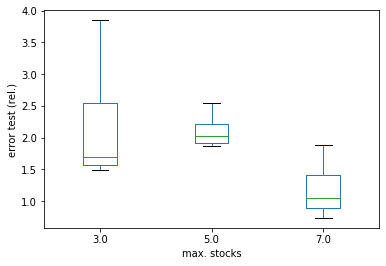

In [6]:
%matplotlib inline

df = scalar_df.pivot(index='trainingdays', columns='maxstock', values='error_test_rel')
df.plot.box()
plt.xlabel('max. stocks')
plt.ylabel('error test (rel.)')
plt.show()

The results here are not so clear as before. Again, we should be able to observe that the error as well as the variance decreases with an increasing number of stocks we are allowed to select.

By plotting the ratio $\frac{error_{test}}{error_{train}}$, we might find out some more about this "sweet spot".

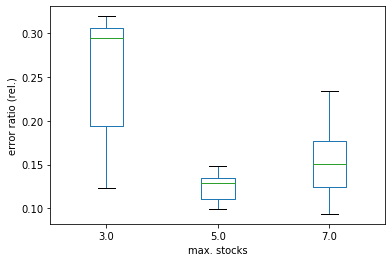

In [7]:
%matplotlib inline

df = scalar_df.pivot(index='trainingdays', columns='maxstock', values='error_ratio_rel')
df.plot.box()
plt.xlabel('max. stocks')
plt.ylabel('error ratio (rel.)')

plt.show()

# How many training days to choose?
The other parameter that is interesting to the planner is how many days to train the model with. Let's take a closer look at this:

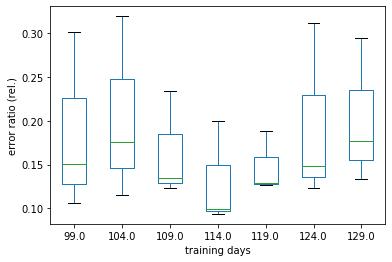

In [8]:
%matplotlib inline
df = scalar_df.pivot(index='maxstock', columns='trainingdays', values='error_ratio_rel')
df.plot.box()
plt.xlabel('training days')
plt.ylabel('error ratio (rel.)')
plt.show()

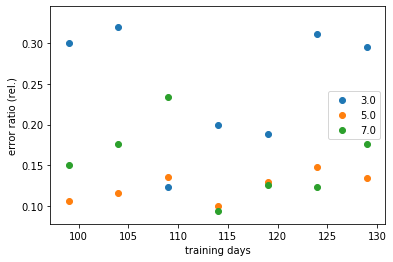

In [9]:
%matplotlib inline

df = scalar_df.groupby('maxstock')
fig, ax = plt.subplots()
for name, grp in df:
    ax.scatter(grp.trainingdays, grp.error_ratio_rel, label=name)
ax.legend()
plt.xlabel('training days')
plt.ylabel('error ratio (rel.)')
plt.show()

Hopefully you will be able to see the impact of over/underfitting the data. If we choose too few training days, we get both high error rates and high variance. We have too little data to get a model that can approximate the Dow Jones reasonably well.
However, if we choose too many training days, we overfit the data.
You may want to try and find the "sweet spot" to determine how much data you should train the model with to get the best approximation.